# The most common traits of substance abuse

In 2017, nearly 20 million American adults (almost 7% of the population) battled a substance abuse problem, costing the US more than $740 billion annually in lost workplace productivity, healthcare expenses, and crime-related costs, according to the [American Addiction Centers](https://americanaddictioncenters.org/rehab-guide/addiction-statistics).

Substance abuse has a cure, but many people are too ashamed to reach out for help, which makes the problem even harder to address.

What if we could tell whether someone has a potential problem with drugs without asking them explicitly? Maybe we could look out for common traits among people who suffer with substance abuse problems and provide aid in advance. Organizations could target ad campaigns at the right people and right moment and increase their effectiveness.

But what would these common traits be?

## 1. Problem understanding

This study will try to answer the following questions:

1. Which age group shows the largest share of people with a possible substance problem? And which gender?

2. Which kind of professional is more vulnerable to substance abuse?

3. Are people with kids or partners less likely to have a substance problem?

4. Are religious people less likely to have a substance problem?

5. Does making healthy choices (e.g., not smoking or eating plant-based diets) correlate negatively with substance abuse?

And last but not least, how accurately can we predict substance abuse with just this bunch of information?

## 2. Data understanding

To tackle the previous questions, I'm going to use the [OkCupid Profile Dataset](https://github.com/rudeboybert/JSE_OkCupid), a file containing answers from 60k users covering a number of topics; from marital status, job, and kids, to alcohol and drugs consumption.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("../data/profiles.csv")

### Selecting the useful variables

These are the variables that will help me address the proposed questions:
- diet
- drinks
- drugs
- job
- offspring
- pets
- religion
- sex
- smokes
- status

Let's ditch all the rest:

- body_type
- education
- ethnicity
- height
- income
- last_online
- location
- orientation
- sign
- speaks
- essay from 0 to 9

In [3]:
df.drop(["body_type", "education", "ethnicity", "height", "income", "last_online", "location", "orientation",
        "sign", "speaks", "essay0", "essay1", "essay2", "essay3", "essay4", "essay5", "essay6",
        "essay7", "essay8", "essay9"], axis=1, inplace=True)

### Variable descriptions

The following details are also provided in the dataset codebook.

Missing data is blank. Some variables have two factors, which are denoted in this codebook by a semicolon (e.g. "graduated from; two-year college) though they are found without punctuation in the dataset. Details for specific variables are found in parenthesis.

**diet** - mostly/strictly; anything, vegetarian, vegan, kosher, halal, other

**drinks** - very often, often, socially, rarely, desperately, not at all

**drugs** - never, sometimes, often

**job** - student, art/music/writing, banking/finance, administration, technology, construction, education, entertainment/media, management, hospitality, law, medicine, military, politics/government, sales/marketing, science/engineering, transportation, unemployed, other, rather not say, retire

**offspring** - has a kid, has kids, doesnt have a kid, doesn't want kids; ,and/,but might want them, wants them, doesnt want any, doesnt want more

**orientation** - straight, gay, bisexual

**pets** - has dogs, likes dogs, dislikes dogs; and has cats, likes cats, dislikes cats

**religion** - agnosticism, atheism, Christianity, Judaism, Catholicism, Islam, Hinduism, Buddhism, Other; and very serious about it, and somewhat serious about it, but not too serious about it, and laughing about it

**sex** - m, f

**smokes** - yes, sometimes, when drinking, trying to quit, no

**status** - single, seeing someone, married, in an open relationship


Let's check if the actual data type is the same as their description in the codebook.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        59946 non-null  int64 
 1   diet       35551 non-null  object
 2   drinks     56961 non-null  object
 3   drugs      45866 non-null  object
 4   job        51748 non-null  object
 5   offspring  24385 non-null  object
 6   pets       40025 non-null  object
 7   religion   39720 non-null  object
 8   sex        59946 non-null  object
 9   smokes     54434 non-null  object
 10  status     59946 non-null  object
dtypes: int64(1), object(10)
memory usage: 5.0+ MB


### Missing values

In [5]:
df.isnull().mean()

age          0.000000
diet         0.406950
drinks       0.049795
drugs        0.234878
job          0.136756
offspring    0.593217
pets         0.332316
religion     0.337404
sex          0.000000
smokes       0.091949
status       0.000000
dtype: float64

The database has 60k rows, but there's a huge number of missing values, especially in the `offspring` column. People have their own personal reasons not to answer a survey, like taboo or fear of exposition. That makes it a MNAR (Missing Not At Random) scenario, which is quite difficult to handle. I'm not a huge fan of imputing the missing values with estimates in this case (even with multivariate methods like KNN) because doing so will likely create some sort of bias. 

However, dropping all missing values at once will drastically reduce statistical power:



In [6]:
df.dropna(axis=0, inplace=True) #, inplace=True)

That will leave us only ~15% of original data, but I think that's the most prudent thing to do instead of coming up with estimates.

Nonetheless, there's no need to drop all the missing rows right now. While analyzing the variables individually, I can drop *just the missing values that belong to the variables being analyzed.* That way, I still got a bit of statistical power for chi-squared tests. After the individual analyzes are done, then all missing values will be dropped before training the machine learning model.

## 3. Preparing the data

### Defining and creating the target variable

First, we need to clearly define what substance abuse is. According to [Wikipedia](https://en.wikipedia.org/wiki/Substance_abuse):

> Substance abuse, also known as drug abuse, is use of a drug in amounts or by methods which are harmful to the individual or others. (...) Drugs most often associated with this term include: alcohol, amphetamines, barbiturates, benzodiazepines, cannabis, cocaine, hallucinogens, methaqualone, and opioids.

The OkCupid dataset isn't precise in terms of which drugs its users consume, but it gives us a few clues about quantity: 

- The `drinks` variable has 6 possible values: very often, often, socially, rarely, desperately, not at all
- The `drugs` variable has 3 possible values: never, sometimes, often

I'm going to assume that users who drink "very often", or use drugs "often" are likely candidates for the group of users with a substance problem. I dismissed "desperately" entries because this sounds more like an answer to signal you're cool.

I'm going to name it as `abuse`, and convert the possible values of `drinks` and `drugs` the variables `alcohol_problem`, `drugs_problem`, and `both_problems`, which will either be 0 or 1. 

In [7]:
# Not considering the "desperately" entries improved the model accuracy at the end of this notebook,
# which kinda proves my point.

# Creates alcohol_problem column with values:
# 1 if drinks = "very often"
# 0 if anything else
df["alcohol_problem"] = df['drinks'].apply(lambda x: 1 if (x=="very often") else 0)

# Creates drugs_problem column with values:
# 1 if drinks = "often"
# 0 if anything else
df["drugs_problem"] = df['drugs'].apply(lambda x: 1 if (x=="often") else 0)

# Users have an abuse problem (abuse = 1) if they have either an alcohol or drug abuse problem;
# variable has int dtype to conform with the other columns, though Python won't really care
df['abuse'] = (df['alcohol_problem'] | df['drugs_problem']).astype(int)

A user may have a drug abuse problem, an alcohol abuse problem, or both. I want to discriminate each so that I can make a stacked bar plot at the analysis section.

In [8]:
df['both_problems'] = (df["drugs_problem"] & df["alcohol_problem"]).astype(int)
df['alcohol_problem_only'] = (df['alcohol_problem'] & ~df['drugs_problem']).astype(int)
df['drugs_problem_only'] = (~df['alcohol_problem'] & df['drugs_problem']).astype(int)


### Age 

Several populational traits have a potentially strong correlation with age (e.g. having kids). Therefore I want to create a variable called `age_group` so that I can assess whether my hypotheses hold for all ages when analyzing the plots.

In [9]:
age_group_labels = ["18 to 24", "25 to 29", "30 to 39", "40+"]
df["age_group"] = pd.cut(df['age'], bins=[18,25,30,40,100], labels=age_group_labels)

The age groups values were decided so that each bin contained roughly the same number of users.

In [10]:
df["age_group"].value_counts()

30 to 39    2212
25 to 29    2120
40+         2026
18 to 24    2025
Name: age_group, dtype: int64

### Gender

In [11]:
# Creates a female variable, so that gender can be either 0 or 1 to maintain the same format as
# the other variables
df["female"] = df["sex"].replace({"m": 0, "f": 1})

### Status

According to the `okcupid_codebook.txt` file, the possible values of `status` are single, seeing someone, married, and in an open relationship. I'll replace the value "available" with the latter since it's more explainative.

In [12]:
df["status"] = df["status"].replace({"available": "in an open relationship"})

### Offspring 

Whoever said that "doesn't have kids" (and might or might not want them), or simply "wants kids" will have the offspring variable set to zero, while everything else will be replaced with ones.

In [13]:
df['offspring'].replace(['doesn&rsquo;t have kids',
                         'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
                         'doesn&rsquo;t have kids, but might want them',
                         'doesn&rsquo;t have kids, but wants them',
                         'might want kids',
                         'doesn&rsquo;t want kids',
                         'wants kids'], 0, inplace=True)

df['offspring'].replace(['has a kid',
                         'has a kid, and might want more',
                         'has a kid, and wants more',
                         'has a kid, but doesn&rsquo;t want more',
                         'has kids',
                         'has kids, and might want more',
                         'has kids, and wants more',
                         'has kids, but doesn&rsquo;t want more',], 1, inplace=True)

### Pets 

In [14]:
df['has_dogs'] = df['pets'].apply(lambda x: 1 if ("has dogs" in x) else 0).astype(int)
df['has_cats'] = df['pets'].apply(lambda x: 1 if ("has cats" in x) else 0).astype(int)

# has_pets = 1 when user either has a dog or a cat
df['has_pets'] = df[['has_dogs', 'has_cats']].any(axis=1).astype(int)

### Religion 

The `religion` variable has several possible values plus a few modifiers ("laughing about it, "somewhat serious about it", etc). I thought of creating a new variable out of these modifiers called `religious`, which is going to be 1 if `religion` is not atheism or agnosticism (for obvious reasons), and the `religion` modifier has the "very serious about it" modifier. 

In [15]:
df.dropna(axis=0, subset=["religion"], inplace=True)
df['religious'] = df['religion'].apply(lambda x: 1 if "very serious" in x else 0)
df['religious'] = ~df['religion'].isin(["agnosticism", "atheism"]) & df['religious'] == 1

df['religion'].replace([" and laughing about it",
                       " and somewhat serious about it",
                       " and very serious about it",
                       " but not too serious about it"], "", regex=True, inplace=True)

### Healthy variables

In [16]:
df["smokes"] = df["smokes"].replace({"yes": 1,
                                    "sometimes": 1,
                                    "when drinking": 1,
                                    "trying to quit": 1,
                                    "no": 0})

The "diet" variable has 6 possible values (anything, vegetarian, vegan, kosher, halal, and other) and 2 modifiers (mostly/strictly), which might create unnecessary dummy variables that won't add value to the model. So let's boil it down to diet type without the nuance.

In [17]:
df['vegetarian'] = df['diet'].apply(lambda x: 1 if ("vegetarian" in x) or ("vegan" in x) else 0)

## 4. Evaluation

Auxiliary functions:

In [18]:
def chi_test(df, column):
    """
    Calculates the p-value of chi-squared tests for a chosen column. The function also
    performs the test for all age group in the DataFrame.
    """
    print("Chi-squared test")
    print("----------------")
    for group in age_group_labels:
        df_group = df[df["age_group"] == group]
        cont_table = pd.crosstab(df_group[column], df_group['abuse'])
        c, p, dof, expected = chi2_contingency(cont_table)
        print(f"Age group: {group}, p = {p:.2g}")

In [19]:
def vert_barplot(df, bars, label, groupby, title=None, color=None, figsize=(10,5)):
    """
    Groups the DataFrame by a specified label (like "age_group), and plots a pretty bar chart
    with custom parameters.
    
    Parameters
    ----------
    
    df : DataFrame
    bars : list of tuples
        Contains pairs of columns labels and values to be plotted.
        Example: [("offspring", 0), ("offspring, 1")]
    groupby : str
        Column label by which the DataFrame is going to be grouped
    title : str
        x-axis label
    color : list
        List of colors to be passed to the plotting method.
    figsize : tuple
        Figure size
    """
    
    table_mean = []
    for i in range(len(bars)):
        col_name = bars[i][0]
        col_value = bars[i][1]
        table_mean.append(df[df[col_name] == col_value]
                                .groupby(groupby)["abuse"]
                                .mean()
                                .to_frame())
    table_p = pd.concat(table_mean, axis=1)
    
    table_percent = table_p * 100  # percentages should be multiplied by 100
    
    
    table_percent.columns = label
    table_percent.plot.bar(figsize=figsize,
                           color=color,
                           rot=0,
                           capsize=0)
    plt.ylabel("% of users with substance problem")
    plt.xlabel(title)
    sns.despine()
    plt.show()

In [20]:
df["abuse"].value_counts()

0    8259
1     203
Name: abuse, dtype: int64

Less than 3% of the users in this dataset have a probable substance problem. This is a specially imbalanced dataset, so any attempts to predict an outcome will likely be impacted. Techniques to deal with it can be found at the end of the document.

### Question #1 - Which age group shows the largest percentage of people with a possible substance addiction problem? And does substance abuse disproportionately affect any gender?

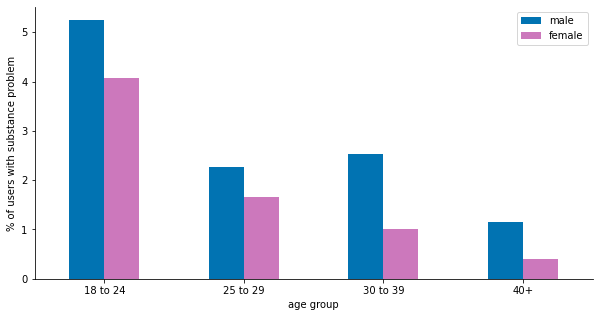

In [21]:
df_drop_sex = df.dropna(axis=0, subset=["sex"])

gender_colors = sns.color_palette("colorblind").as_hex()
color=[gender_colors[0], gender_colors[4]]
vert_barplot(df=df,
             bars=[("female", 0), ("female", 1)],
             label=["male", "female"],
             groupby="age_group",
             title="age group",
             color=color)

In [22]:
chi_test(df, "female")

Chi-squared test
----------------
Age group: 18 to 24, p = 0.26
Age group: 25 to 29, p = 0.41
Age group: 30 to 39, p = 0.014
Age group: 40+, p = 0.1


### Question #2 - Which kind profession is more vulnerable to substance abuse?

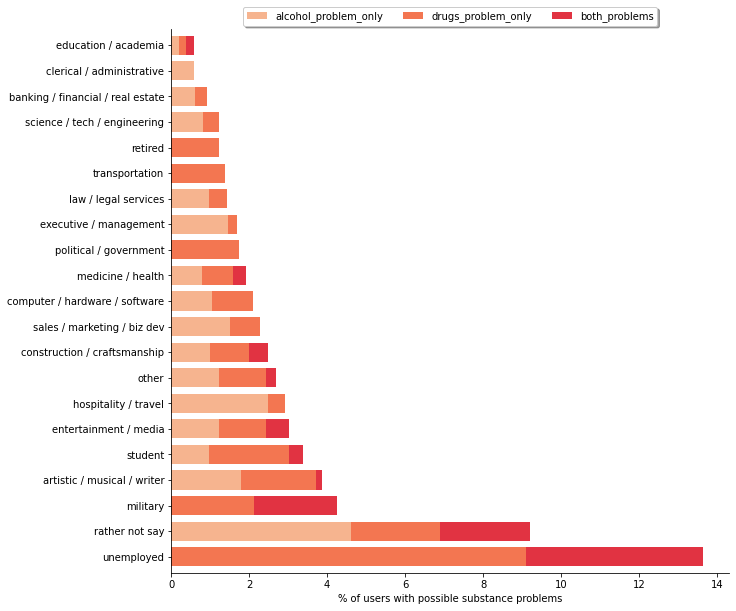

In [23]:
sns.set_palette("rocket_r")

jobs_stacked = df.groupby("job").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
jobs_stacked.drop('abuse', axis=1, inplace=True)
jobs_stacked.plot(kind='barh', stacked=True, figsize=(10,10), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

### Question #3 - Are people with kids or partners less likely to have a substance abuse problem?


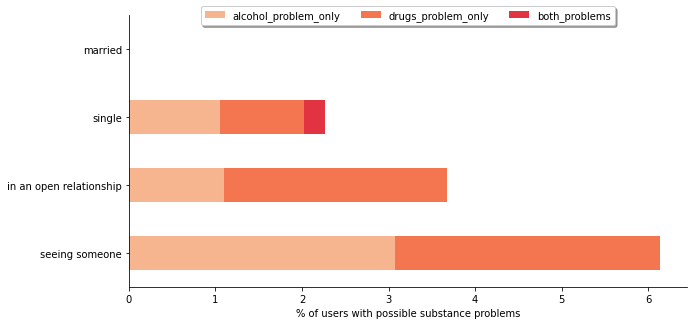

In [24]:
sns.set_palette("rocket_r")

status_stacked = df.groupby("status").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
status_stacked.drop('abuse', axis=1, inplace=True)
status_stacked.plot(kind='barh', stacked=True, figsize=(10,5), width=0.5, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

There's also the problem of colinearity with age. Young adults are much less likely to have kids, and that will impact the outcome of the correlation study with substance abuse. It would be more reasonable to observe differences by age groups.

In [25]:
table_offspring = pd.concat([df["age_group"].value_counts(), (1-df.groupby("age_group")["offspring"].mean())*100], axis=1)
table_offspring.columns = ["no. of users", "percentage without kids"]
table_offspring.index.rename("age group", inplace=True)
table_offspring

,no. of users,percentage without kids
age group,,
18 to 24,2025,97.086420
25 to 29,2120,96.603774
30 to 39,2212,85.940325
40+,2026,46.989141


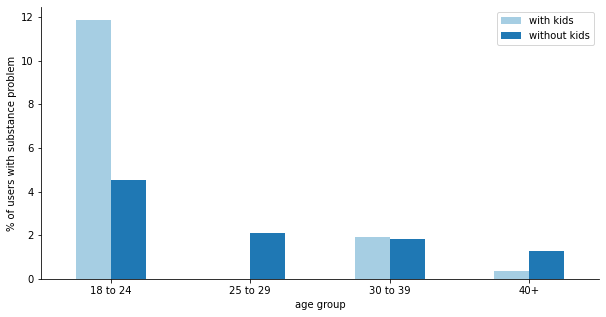

In [26]:
vert_barplot(df=df,
             bars=[("offspring", 1), ("offspring",0)], 
             label=["with kids", "without kids"],
             groupby="age_group",
             title="age group",
             color=sns.color_palette("Paired"))

In [27]:
chi_test(df, "offspring")

Chi-squared test
----------------
Age group: 18 to 24, p = 0.021
Age group: 25 to 29, p = 0.41
Age group: 30 to 39, p = 0.9
Age group: 40+, p = 0.045


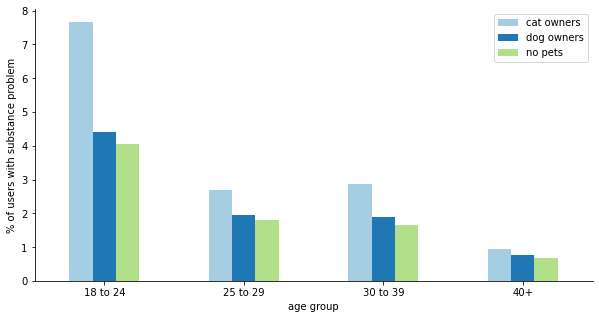

In [28]:
vert_barplot(df=df,
             bars=[("has_cats", 1), ("has_dogs",0), ("has_pets", 0)], 
             label=["cat owners", "dog owners", "no pets"],
             groupby="age_group",
             title="age group",
             color=sns.color_palette("Paired"))

In [29]:
chi_test(df, "has_cats")

Chi-squared test
----------------
Age group: 18 to 24, p = 0.012
Age group: 25 to 29, p = 0.53
Age group: 30 to 39, p = 0.13
Age group: 40+, p = 0.85


In [30]:
chi_test(df, "has_dogs")

Chi-squared test
----------------
Age group: 18 to 24, p = 0.26
Age group: 25 to 29, p = 0.75
Age group: 30 to 39, p = 0.95
Age group: 40+, p = 0.99


### Question #4 - Are religious people less likely to have a substance abuse problem?

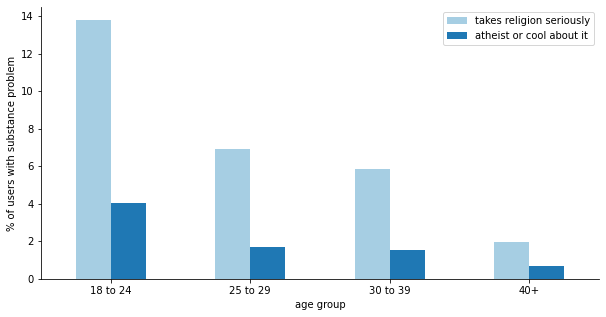

In [31]:
vert_barplot(df=df,
             bars=[("religious", 1), ("religious",0)], 
             label=["takes religion seriously", "atheist or cool about it"],
             groupby="age_group",
             title="age group",
             color=sns.color_palette("Paired"))

In [32]:
chi_test(df, "religious")

Chi-squared test
----------------
Age group: 18 to 24, p = 3e-07
Age group: 25 to 29, p = 6.2e-05
Age group: 30 to 39, p = 0.00047
Age group: 40+, p = 0.22


### Question #5 - Does making healthy choices (e.g., not smoking or eating plant-based diets) correlate negatively with substance abuse?

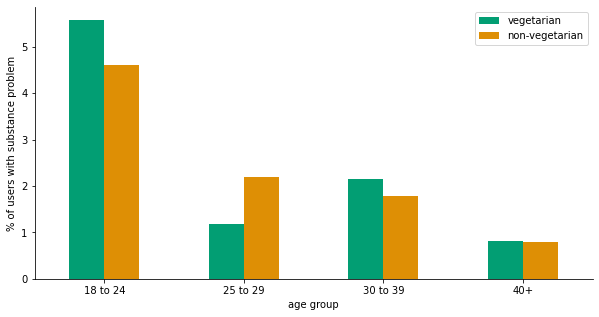

In [33]:
palette = sns.color_palette("colorblind").as_hex()
color = [palette[2], palette[1]]
vert_barplot(df=df,
             bars=[("vegetarian", 1), ("vegetarian",0)], 
             label=["vegetarian", "non-vegetarian"],
             groupby="age_group",
             title="age group",
             color=color)

In [34]:
chi_test(df, "vegetarian")

Chi-squared test
----------------
Age group: 18 to 24, p = 0.59
Age group: 25 to 29, p = 0.33
Age group: 30 to 39, p = 0.8
Age group: 40+, p = 0.78


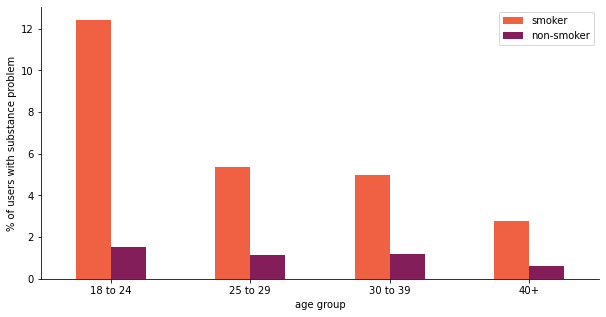

In [35]:
vert_barplot(df=df,
             bars=[("smokes", 1), ("smokes",0)], 
             label=["smoker", "non-smoker"],
             groupby="age_group",
             title="age group",
             color=sns.color_palette("rocket_r", n_colors=2))

In [36]:
chi_test(df, "smokes")

Chi-squared test
----------------
Age group: 18 to 24, p = 3e-25
Age group: 25 to 29, p = 5.3e-08
Age group: 30 to 39, p = 1.9e-06
Age group: 40+, p = 0.0063


### Model evaluation

Let's clear up all unused columns.

In [37]:
df["unemployed"] = (df["job"] == "unemployed") | (df["job"] == "rather not say")
df["married"] = df["status"] == "married"

In [38]:
df_useful = df.drop(["diet","pets","religion","age_group", "alcohol_problem",
                    "alcohol_problem_only", "drugs_problem", "drugs_problem_only",
                    "both_problems", "has_pets", "job", "status", "sex","drinks", "drugs"], axis=1)

There are a few categorical variables remaining. Let's transform them into dummy variables.

In [39]:
df_useful.dtypes

age           int64
offspring     int64
smokes        int64
abuse         int64
female        int64
has_dogs      int64
has_cats      int64
religious      bool
vegetarian    int64
unemployed     bool
married        bool
dtype: object

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score, plot_roc_curve
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline

To ensure convergence, I'm going to create a pipeline and pre-treat the data with StandardScaler.

In [41]:
model = make_pipeline(StandardScaler(), LogisticRegression())

y = df_useful["abuse"]
X = df_useful.drop(["abuse"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Our dataset is severely imbalanced and all attempts to train the model will be impacted unless we deal with it first. I decided to upsample the training set, which means randomly replicating positive cases until we have 50/50 classes.

In [42]:
# concatenate our training data back together
df_train = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_abuse = df_train[df_train["abuse"] == 0]
abuse =  df_train[df_train["abuse"] == 1]

# upsample minority
abuse_upsampled = resample(abuse,
                          replace=True, # sample with replacement
                          n_samples=len(not_abuse), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_abuse, abuse_upsampled])

y_train = upsampled.abuse
X_train = upsampled.drop('abuse', axis=1)

In [43]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [45]:
coef_table = pd.DataFrame(model.named_steps["logisticregression"].coef_[0], index=X_train.columns, columns=["coef"])
coef_table

,coef
age,-0.515595
offspring,0.047919
smokes,0.794454
female,-0.247888
has_dogs,-0.045085
has_cats,0.325116
religious,0.390841
vegetarian,0.018743
unemployed,0.333458
married,-0.419006


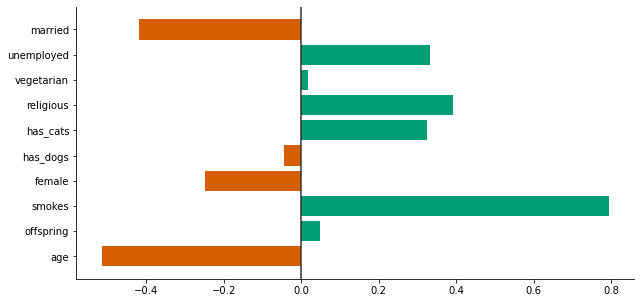

In [46]:
palette = sns.color_palette("colorblind").as_hex()
colors = [palette[3] if x < 0 else palette[2] for x in coef_table.values]
pos = np.arange(len(coef_table))
plt.figure(figsize=(10,5))
plt.barh(pos, coef_table["coef"], color=colors)
plt.yticks(pos, coef_table.index)
plt.axvline(x=0, color='.2')
sns.despine()

In [47]:
print("Accuracy:",model.score(X_test, y_test))
print("Recall:",recall_score(y_test, model.predict(X_test)))
print("F1 Score:",f1_score(y_test, model.predict(X_test)))
print("ROC AUC:",roc_auc_score(y_test, model.predict(X_test)))

Accuracy: 0.7784997046662729
Recall: 0.825
F1 Score: 0.14965986394557823
ROC AUC: 0.8011872353297035


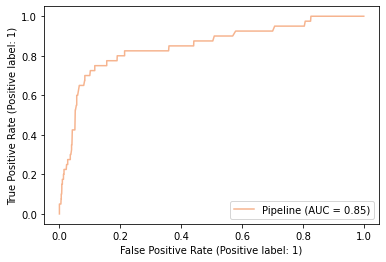

In [48]:
plot_roc_curve(model, X_test, y_test)

In [49]:
print("Recall: {:.2f}".format(recall_score(y_test, model.predict(X_test))))

Recall: 0.82


In [50]:
(y_test == model.predict(X_test))[y_test == 0].mean()

0.7773744706594071